# Responsible AI - Lecture 1 (Hands-on)
# TAIA - Advanced Topics on Artificial Intelligence
# Tiago Filipe Sousa Gonçalves
# tiago.f.goncalves@inesctec.pt | tiagofs@fe.up.pt


# Contents


## 1.   Interpreting Deep Neural Networks with [Captum](https://captum.ai/)
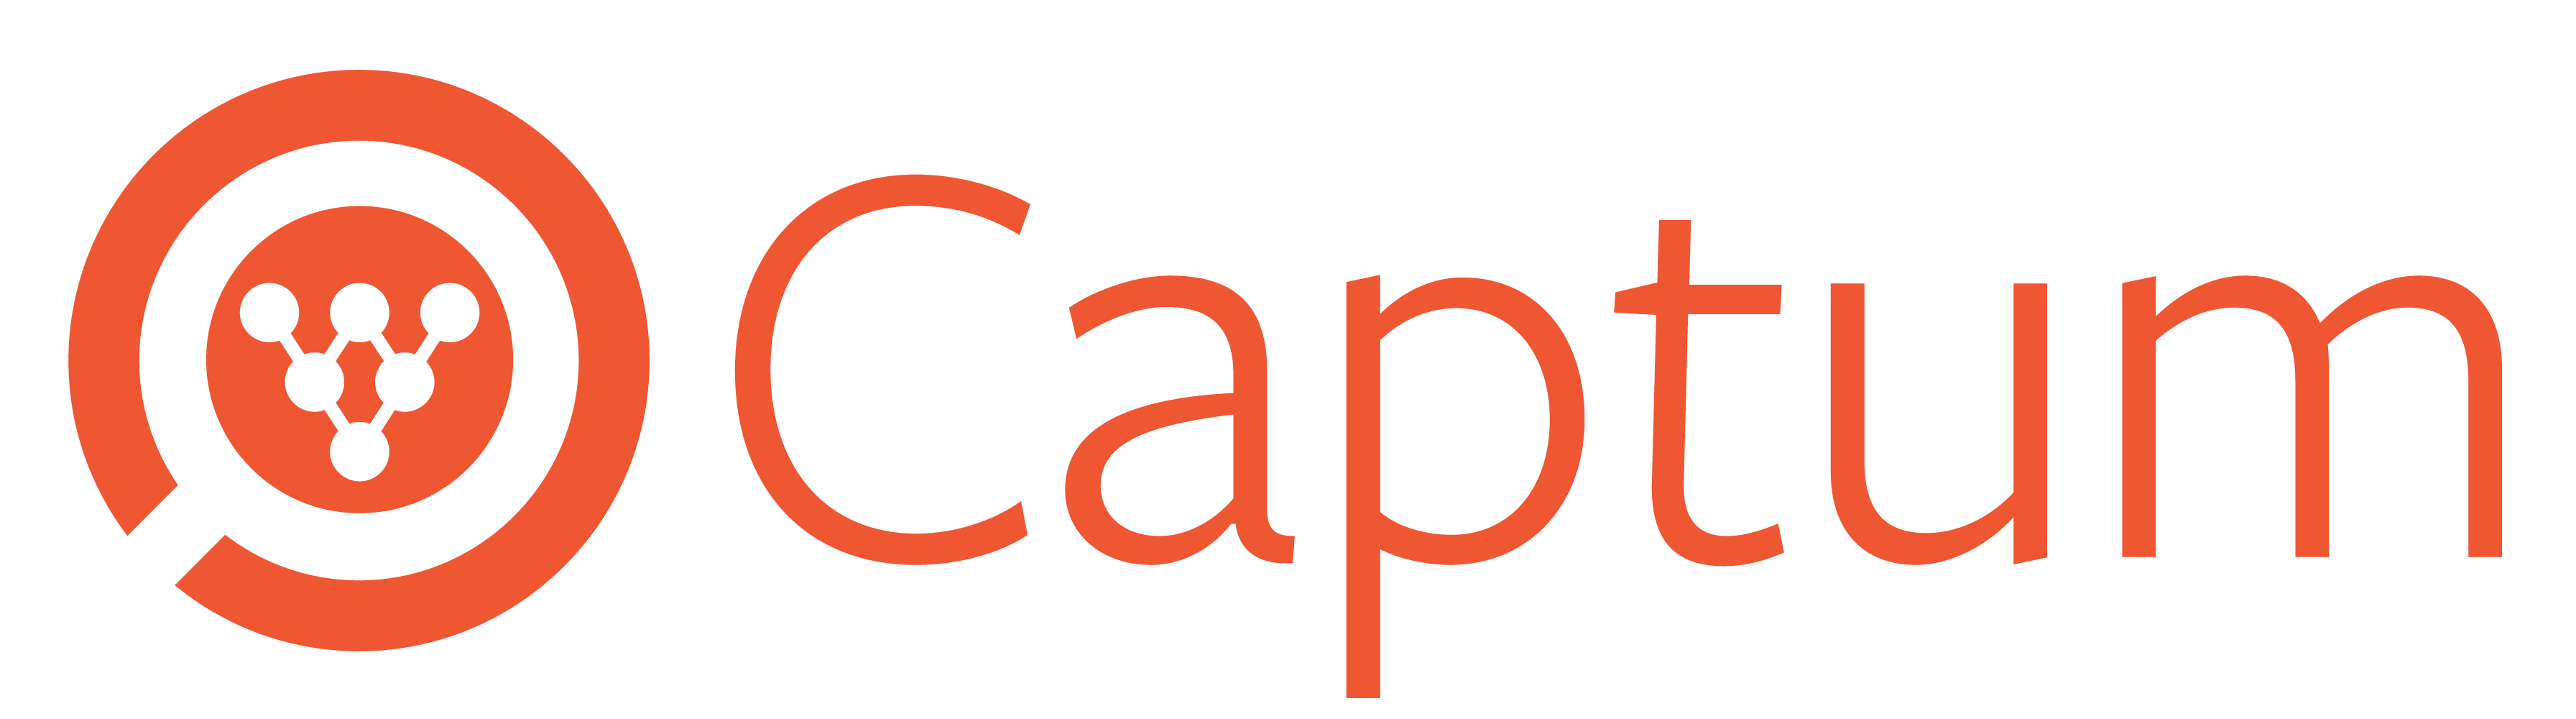

## Setup
Let's start with the setup of our development environment:

In [ ]:
# Install libraries
!pip install captum

Let's import the necessary libraries to run this project:

In [ ]:
# Imports
import os
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Matplotlib Definitions
%matplotlib inline

# PyTorch Imports
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision import models

# Captum Imports
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import visualization as viz

In [ ]:
# Define some helper functions
# Function to show sample images
def imshow(img, transpose = True):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to get the explanations
def attribute_image_features(algorithm, input, **kwargs):
    tensor_attributions = algorithm.attribute(input, target=labels[ind], **kwargs)
    
    return tensor_attributions

## Interpreting a benchmark model using Captum
### Based on ["Showcases integrated gradients on CIFAR10 dataset"](https://captum.ai/tutorials/Resnet_TorchVision_Interpret) and ["Model Interpretation for Pretrained ResNet Model"](https://captum.ai/tutorials/Resnet_TorchVision_Interpret) from [Captum](https://captum.ai/)
Let's start with the setup of our development environment:

In [ ]:
# Let's load the model (ResNet50)
model = models.resnet50(pretrained=True)

# Change the FC-layer to be compatible with CIFAR10 Dataset (only has 10 classes)
model.fc = torch.nn.Linear(2048, 10)

## Let's try to load some data


In [ ]:
# Define some torchvision transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Train Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)

# Test Dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# Define the CIFAR10 Classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Let's train the model for a few epochs

In [ ]:
# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Put model in GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

In [ ]:
# Start training loop
for epoch in range(1):

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          model.to(device)
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % 2000 == 1999:    # print every 2000 mini-batches
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
              running_loss = 0.0

print('Finished Training')
torch.save(model.state_dict(), 'resnet50_cifar_torchvision.pt')

In [ ]:
# Get a sample image
dataiter = iter(testloader)
images, labels = dataiter.next()

# Print and show images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


# Get image classification
model.to('cpu')
outputs = model(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

## Let's now choose a sample image and generate several visual explnations (saliency maps)

In [ ]:
# We can choose an index
ind = 0

# Prepare the inputs to the the function that will generate the explanations
input = images[ind].unsqueeze(0)
input.requires_grad = True

In [ ]:
# Put the model in evaluation mode
model.eval()

# Generate the visual explnations (saliency maps)
# Saliency Maps
saliency = Saliency(model)
# Reset model's gradients
model.zero_grad()
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

# Integrated Gradients
ig = IntegratedGradients(model)
# Reset model's gradients
model.zero_grad()
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

# Integrated Gradients w/ Noise Tunnel
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
# Reset model's gradients
model.zero_grad()
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq', nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))



# And let's now visualise the different types of explanations
print('Original Image')
print('Predicted:', classes[predicted[ind]], ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value", show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all", show_colorbar=True, title="Overlayed Integrated Gradients")

_ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value", outlier_perc=10, show_colorbar=True, title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

## Challenge: Can you apply this to a different pre-trained model?